# Evil Geniuses Data Scientist Intern Assessment

#### David Shin

This notebook contains the code for the Starcraft Rank Prediction Analysis

In [1]:
# analytics stack
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy import stats

# modeling stack
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('starcraft_player_data.csv') # read in dataset
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


In [3]:
df.shape

(3395, 20)

### Data Cleaning

In [4]:
df.dtypes # look at data types

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [5]:
df.tail() # missing values are listed as question marks

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
3394,10095,8,?,?,?,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


In [6]:
missing_values = 0 # variable to store number of rows that contain a missing value
for i in range(len(df)):
    if '?' in df.iloc[i,:].values: # check if ? is in row
        missing_values += 1
print(str(missing_values) + ' Rows with Missing Values')

57 Rows with Missing Values


In [7]:
len(df[(df['TotalHours'] == '?') & (df['LeagueIndex'] == 8)]) # number of rows with League Index 8 that are missing values

55

In [8]:
df['LeagueIndex'].value_counts() # number of records in each League Index class

4    811
5    806
6    621
3    553
2    347
1    167
8     55
7     35
Name: LeagueIndex, dtype: int64

Since there are only 57 rows with missing values, we could just drop the rows as they only make up 1.6% of the dataset. However, when we look closer at the rows with missing values, we can see that all of our data points for players with a League Index of "8" are missing values. The most straightforward way to deal with this would have been to replace the missing values with the average of the column based on rank. Since all the rows with the professional rank are missing values, this is not possible. There are multiple ways to deal with this missing data. Dropping the data points with the professional League Index is not a feasible option as one of the most strategic uses for this model could be to scout high-ranked players that have professional-level game mechanics. Filling in the missing values with basic imputations like the median or mean of the column is also not optimal, as all the data points with professional players would have the same values for Age, HoursPerWeek and TotalHours. The non-existent variability in the columns and biases from having so many rows with the same values would easily cause the model to overfit or underfit. We will use imputation techniques to fill in these missing values.

In [9]:
df.replace('?', np.nan, inplace=True) # replace all ? with np.nan

## Exploratory Data Analysis

In [10]:
df_eda = df.copy() # create copy of df to use for eda
df_eda = df_eda.drop(columns = ['GameID']) # drop GameID column

# convert Age, HoursPerWeek and TotalHours to numerical columns
df_eda[['Age','HoursPerWeek','TotalHours']] = df_eda[['Age','HoursPerWeek','TotalHours']].astype(float)

In [11]:
df_eda.dtypes

LeagueIndex               int64
Age                     float64
HoursPerWeek            float64
TotalHours              float64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

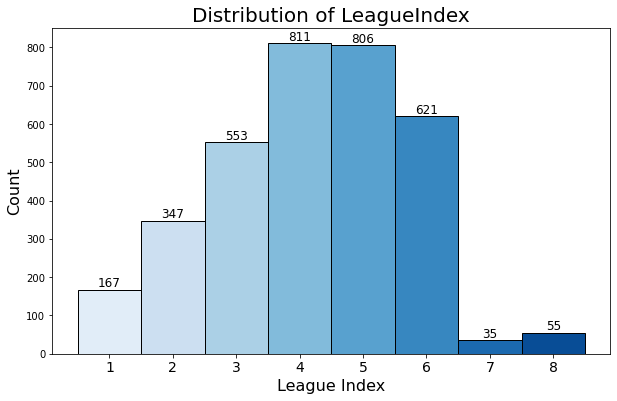

In [12]:
# set figure size
plt.figure(figsize=(10, 6))

# splitting the palette into bins
cm = sns.color_palette('Blues',8) 

# create the histogram
hist_plot = sns.histplot(data = df_eda.sort_values('LeagueIndex').astype(str), x = 'LeagueIndex')

# set color for each bar
for bin_,i in zip(hist_plot.patches,cm):
    bin_.set_facecolor(i)

# format the plot
plt.title('Distribution of LeagueIndex', fontsize = 20) # set title
plt.xlabel('League Index', fontsize=16) # set x label
plt.ylabel('Count', fontsize=16) # set y label
plt.xticks(fontsize=14) # chance x tick size

# get y-axis values for labels
bars = hist_plot.patches
heights = [bar.get_height() for bar in bars]

# create labels for each bar in histogram
for i, v in enumerate(heights):
    plt.text(i, v, f'{str(round(v,2))}', ha='center', va='bottom', fontsize=12)  
plt.savefig('1_league_distribution.png', bbox_inches='tight')
plt.show()

The dataset has a very imbalanced class distribution. League Index 4 has the most records in the data with 811, and League Index 7 has the least at 35. The class imbalance will likely lead to biased model performance and poor generalization, so using techniques to address this class imbalance will be important. Let us now look at the distributions of our predictor variables.

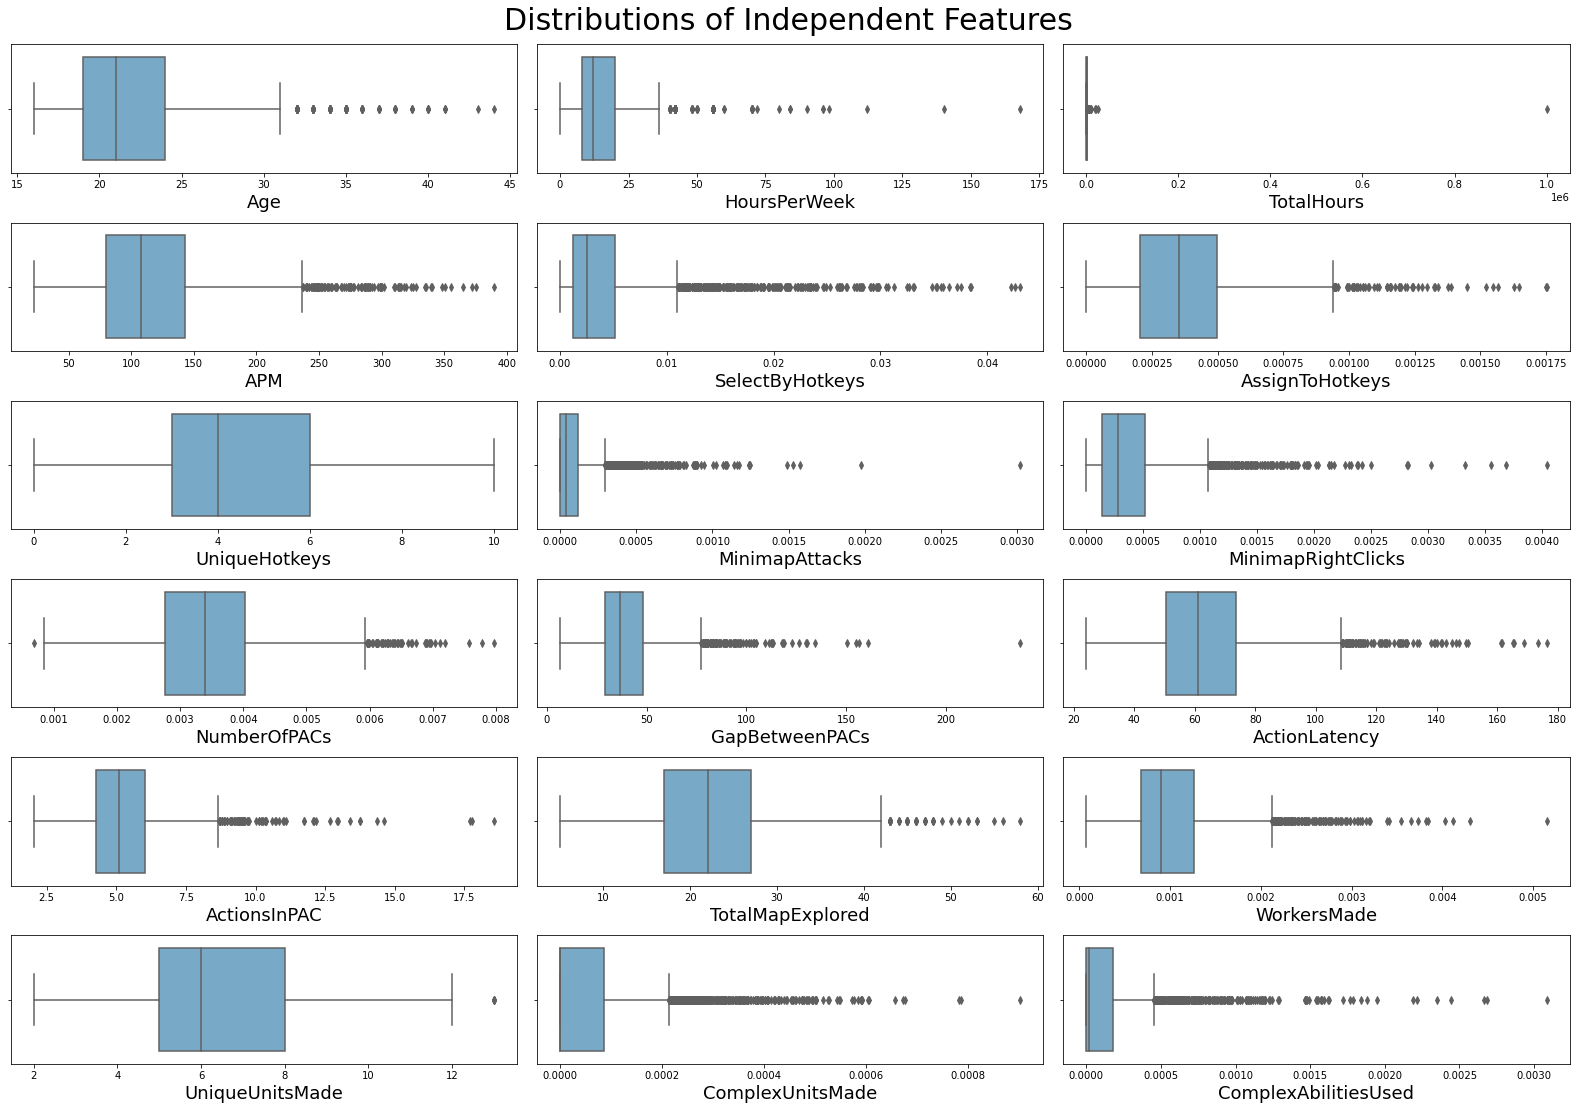

In [13]:
# set figure size
fig = plt.figure(figsize=(22, 15))

# set dimensions of graph matrix
cols = 3  
rows = 6  

# loop over the numerical variables and create subplots with boxplots
for i, var in enumerate(df.columns[2:]):
    plt.subplot(rows, cols, i+1)
    sns.boxplot(x=df_eda[var], palette = 'Blues')
    plt.xlabel(var, fontsize = 18)
    plt.tight_layout()

fig.suptitle('Distributions of Independent Features', fontsize = 30, y = 1.025) # set title
plt.savefig('2_predictor_distributions', bbox_inches='tight') # save image
plt.show()

Looking at the distributions for all of our predictor variables, a few things pop out:
- Many of our variables have distributions that are skewed to the right. This is especially apparent when looking at the box plots of the SelectByHotKeys, ComplexUnitsMade and ComplexAbilitiesUsed.
- TotalHours has an outlier that is 1,000,000 total hours. This is likely an error in the data as 1 million total hours would be the equivalent of playing for about 114 years.
- Many of our variables have points that are beyond the 3rd Quantile Whisker in the boxplot. Because so many of the variables are heavily skewed, it is difficult to determine if these data points are true "outliers" or simply show the diversity in these in-game skills. It may be beneficial to scale these variables using log transformations to reduce the impact of the "outliers". 
- Because so many of our variables have outliers / skewed distributions, we will likely focus on tree-based models as they are less sensitive to noise. 

In [14]:
# record that has totalhours of 1,000,0000
th_index = df_eda[df_eda['TotalHours'] == 1000000].index[0]

# drop the row
df_eda.drop(index=th_index, inplace=True)
df_eda.reset_index(inplace = True, drop = True) # reset index

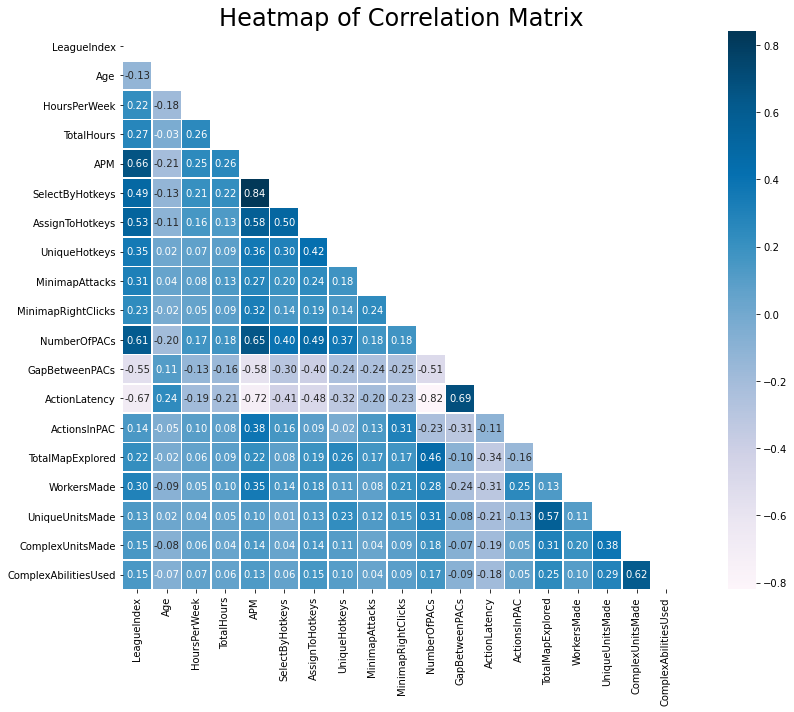

In [15]:
# create correlation table
corr = df_eda.corr()

# create mask
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True


# create heatmap of correlations
plt.figure(figsize=(14,10)) # figure size 
sns.heatmap(corr,center = 0, fmt = '.2f', square = True, annot = True, linewidth = .5,mask = mask, cmap = 'PuBu') # create heatmap
plt.title('Heatmap of Correlation Matrix', fontsize = 24)
plt.tight_layout() # layout formatting
plt.savefig('heatmap', bbox_inches = 'tight')
plt.show()

It's possible that the distributions are heavily skewed right because these represent the values for high-ranking players, for whom we have little data. We will look at the distributions of the variables that have skewed distributions and are correlated with league index

In [16]:
def show_distribution(df, x, y, rounding):
    # create a figure and axes for subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # create boxplot
    sns.boxplot(data=df, x = x, y = y, palette = 'Blues', ax=axes[0])
    axes[0].set_title(f'Distribution of {y} by {x}', fontsize = 18)

    # create bar chart
    df_average = df.groupby(x).mean().sort_values(y)
    sns.barplot(data = df_average, x = df_average.index, y=y, palette = 'Blues', ax=axes[1], ci=None)
    axes[1].set_title(f'Average {y} by {x}', fontsize = 18)
    
    # format graph
    for i in range(0,2):
        axes[i].set_xlabel(x, fontsize=16) # x-axis label
        axes[i].set_ylabel(y, fontsize=16) # y-axis label
        axes[i].tick_params(axis='x', labelsize=12) # x-axis tick font size
        axes[i].tick_params(axis='y', labelsize=12) # y-axis tick font size
    
    # get y-values for each bar in bar chart
    y_values = [bar.get_height() for bar in axes[1].patches]

    # assign labels for each bar
    for i, v in enumerate(y_values):
        plt.text(i, v, f'{str(round(v,rounding))}', ha='center', va='bottom', fontsize=12) 
    plt.savefig(f'Distribution of {y}', bbox_inches = 'tight')
    plt.show()

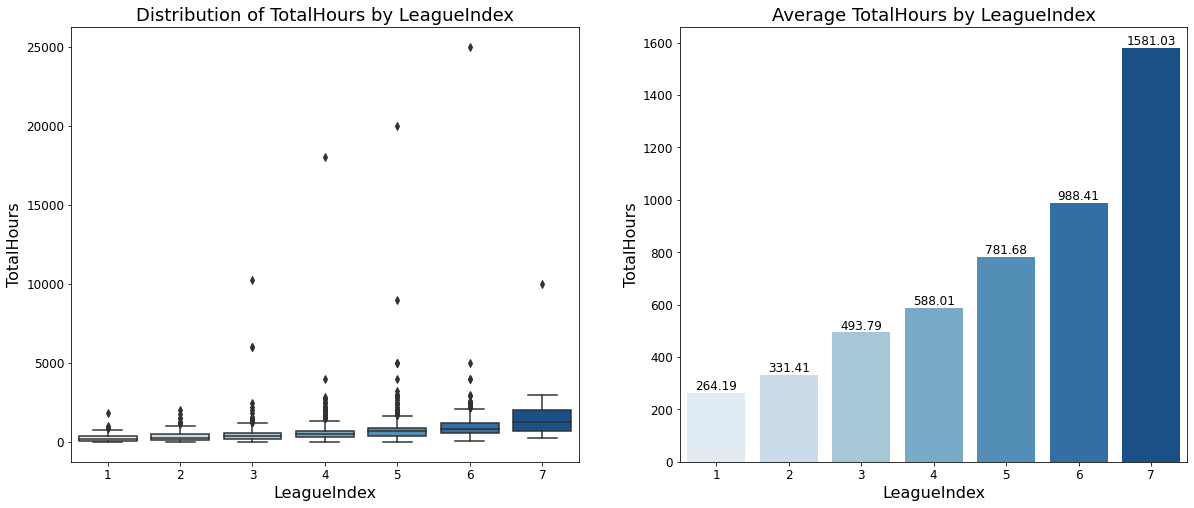

In [17]:
show_distribution(df = df_eda[df_eda['LeagueIndex'] != 8], x = 'LeagueIndex', y = 'TotalHours', rounding = 2) # data points from professional players are missing all values for HoursPerWeek

There are 168 hours in a week, and we can see that some players are reporting that they average more than 12 hours a day. While there are likely players that do fit this criteria, we can see that the highest value is at about 168, meaning that player plays SCII 24 hours a day. My initial thought was that this variable includes time spent on the SCII client, but the data dictionary tells us that the HoursPerWeek variable is self-reported, so we cannot really be sure if this data is incorrect. 

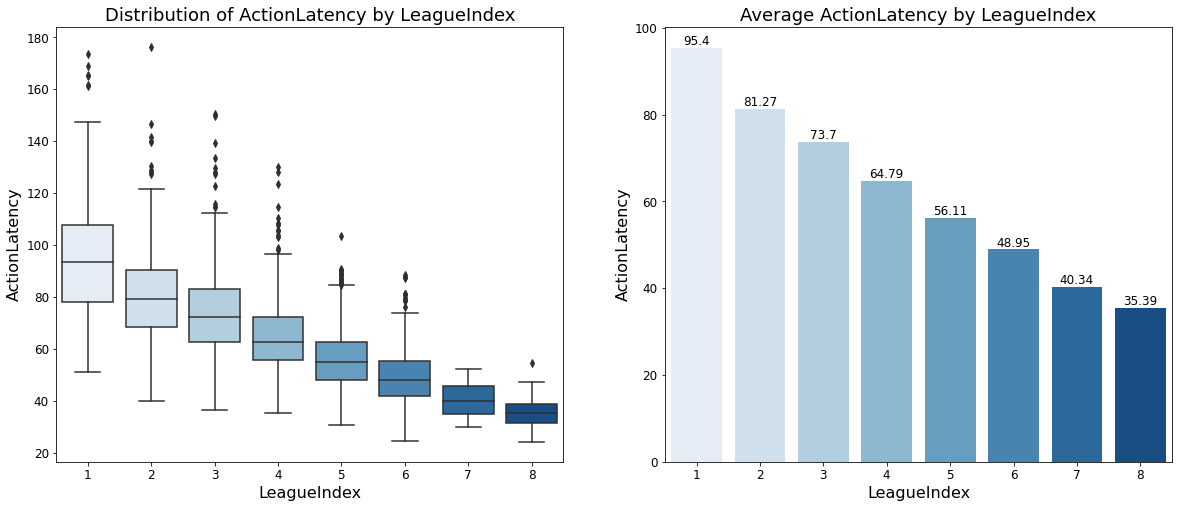

In [18]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'ActionLatency', rounding = 2)

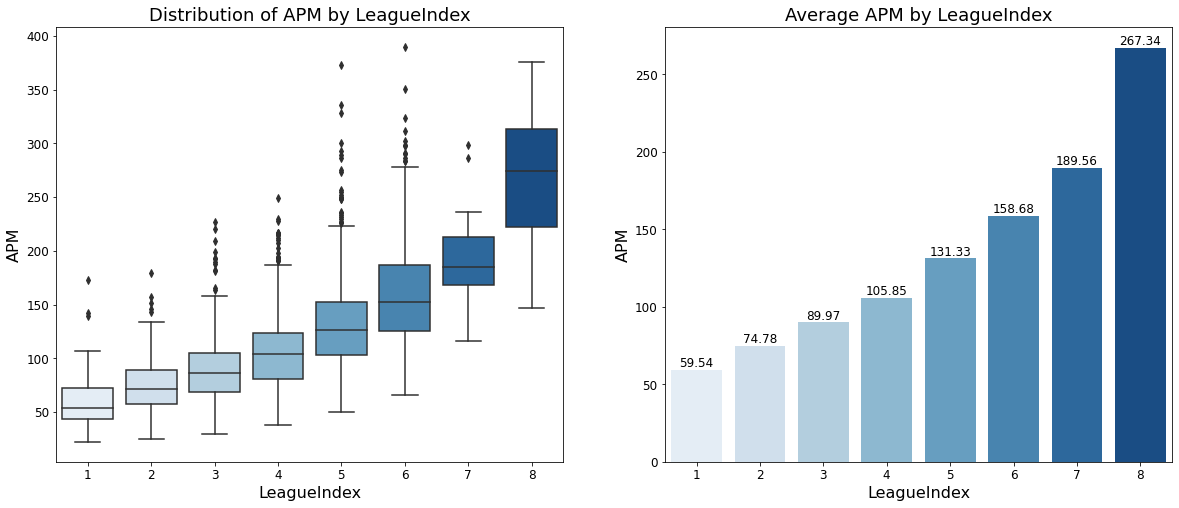

In [19]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'APM', rounding = 2)

APM has a skewed right distribution for almost every LeagueIndex value

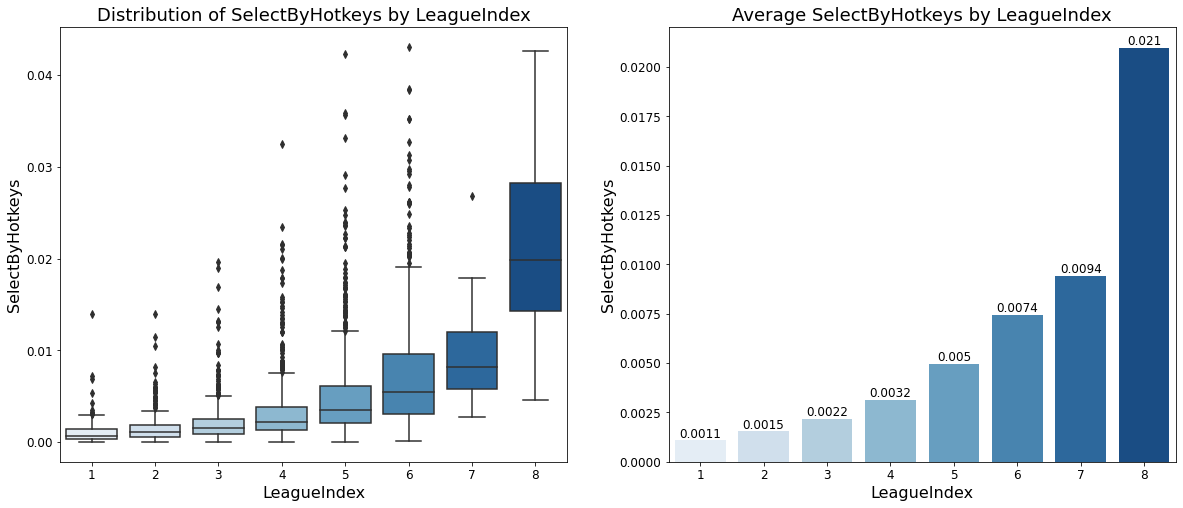

In [20]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'SelectByHotkeys', rounding = 4)

SelectByHotkeys has a heavily skewed right distribution for almost every LeagueIndex value

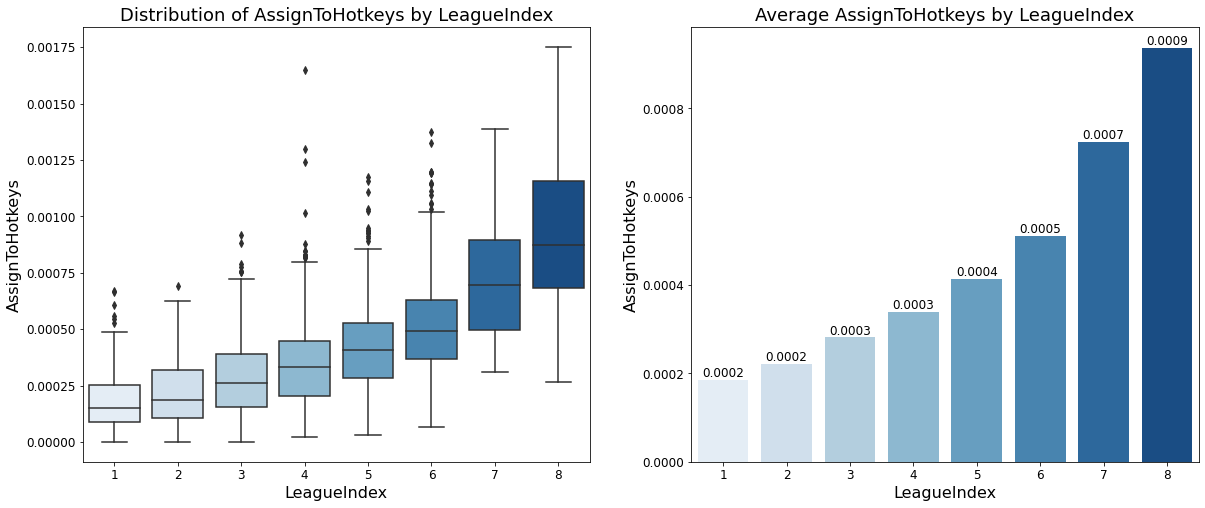

In [21]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'AssignToHotkeys', rounding = 4)

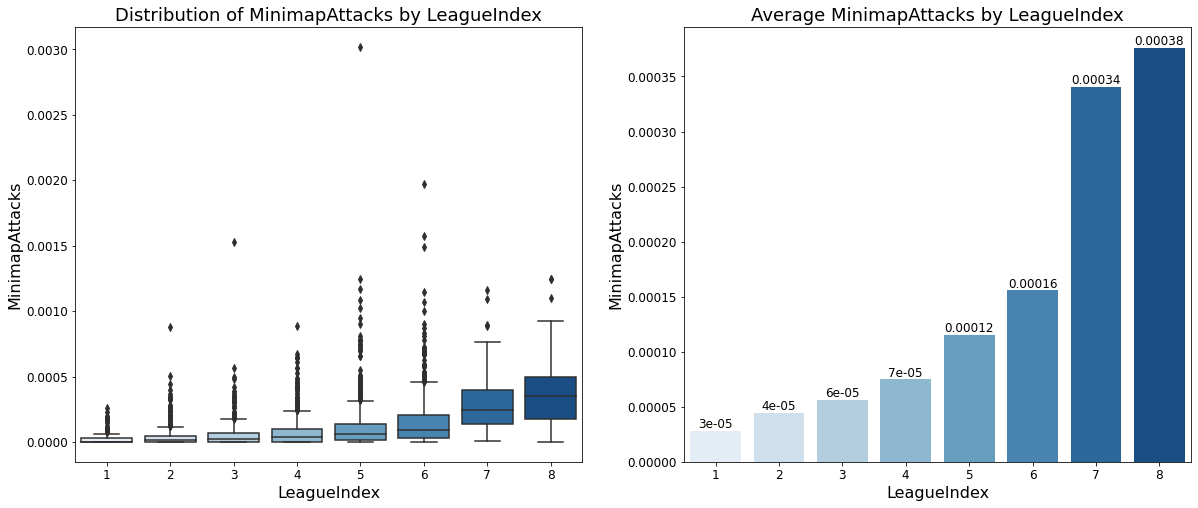

In [22]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'MinimapAttacks', rounding = 5)

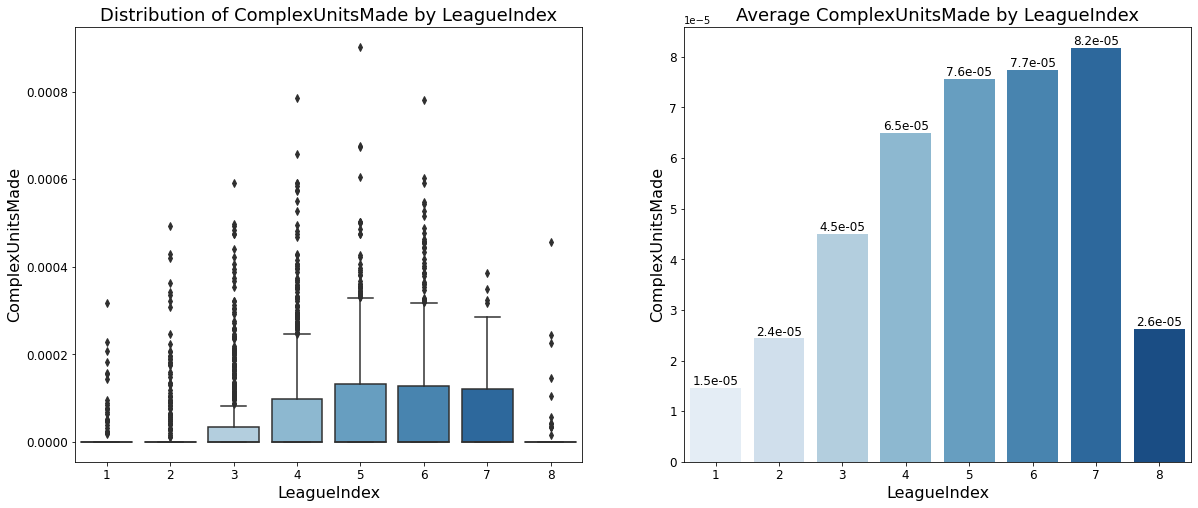

In [23]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'ComplexUnitsMade', rounding = 6)

ComplexUnitsMade is interesting because the average per LeagueIndex steadily increases until the professional rank, where it sharply drops to an average similar to LeagueIndex 2. 

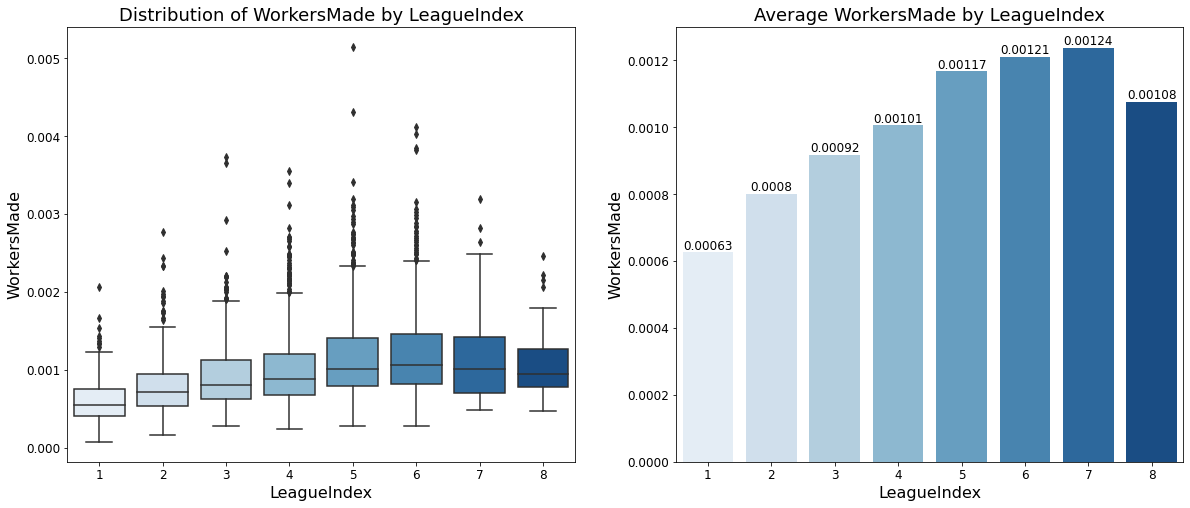

In [24]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'WorkersMade', rounding = 5)

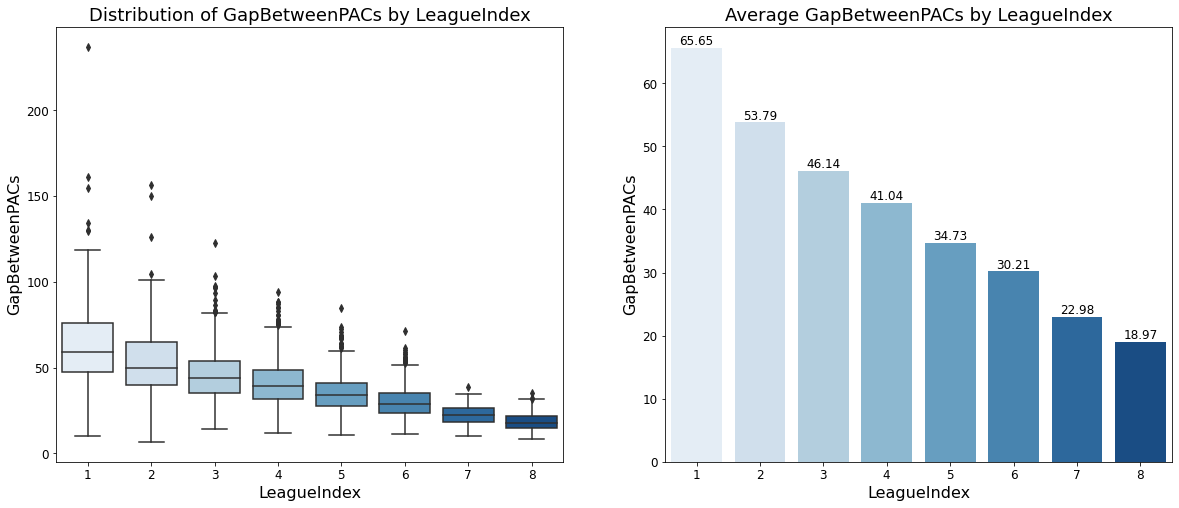

In [25]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'GapBetweenPACs', rounding = 2)

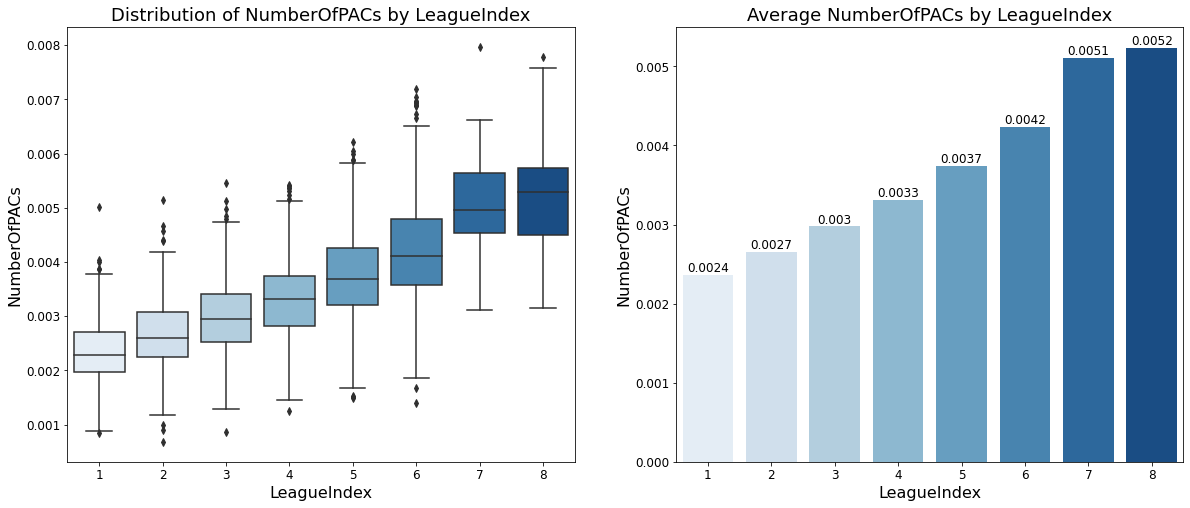

In [26]:
show_distribution(df = df_eda, x = 'LeagueIndex', y = 'NumberOfPACs', rounding = 4)

When we look at the boxplots after they are separated by LeagueIndex, many of the "outliers" from the boxplots of LeagueIndex 1 - 6 are within the normal range of the boxplots for ranks 7 and 8. This supports our initial thoughts that the distributions of our variables are so skewed because of the class imbalance in our dataset.

## Model Building

We will start the modeling process by imputing values for the missing values in the Age, HoursPerWeek and Total Hours columns. After, we will use a Random Forest Classifier to assess the feature importance scores of our variables in order to select features for model testing.

In [27]:
# KNN-based imputation
imputer = KNNImputer(n_neighbors=10)
df_final = pd.DataFrame(imputer.fit_transform(df_eda), columns=df_eda.columns)
df_final.tail()

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
3389,8.0,18.4,35.2,3773.0,259.6296,0.020425,0.000743,9.0,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46.0,0.000877,5.0,0.000000,0.000000
3390,8.0,22.2,22.2,981.0,314.6700,0.028043,0.001157,10.0,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16.0,0.000788,4.0,0.000000,0.000000
3391,8.0,21.2,24.6,1026.0,299.4282,0.028341,0.000860,7.0,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19.0,0.001260,4.0,0.000000,0.000000
3392,8.0,21.0,25.0,1299.0,375.8664,0.036436,0.000594,5.0,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15.0,0.000613,6.0,0.000000,0.000631
3393,8.0,21.4,23.8,1329.0,348.3576,0.029855,0.000811,4.0,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27.0,0.001566,7.0,0.000457,0.000895


To deal with the class imbalance, I tried undersampling. However, this lowered overall accuracy which is likely due to the reduced number of records for training. Moving forward, we will deal with the class imbalance by using the 'class_weight' parameter that is available for Sci-kit Learn classification algorithms

In [28]:
# from imblearn.under_sampling import RandomUnderSampler

# # initiate undersampler
# rus = RandomUnderSampler(random_state=42)

# # undersampling
# X_resampled, y_resampled = rus.fit_resample(X, y)

# # convert the undersampled data back to a DataFrame
# df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
# df_resampled['label'] = y_resampled

### Feature Selection

In [29]:
X = df_final.iloc[:,1:] # subset only predictor variables
scaler = RobustScaler() # initiate robust scaler
X_scaled = scaler.fit_transform(X) # scale predictor variables

y = df_final['LeagueIndex'].values # subset labels

In [30]:
# random forest classification model
model = RandomForestClassifier(class_weight = 'balanced') # set class_weight to balanced to account for unbalanced class distribution

# fit the model
model.fit(X_scaled, y)

# get feature importances
importance = model.feature_importances_

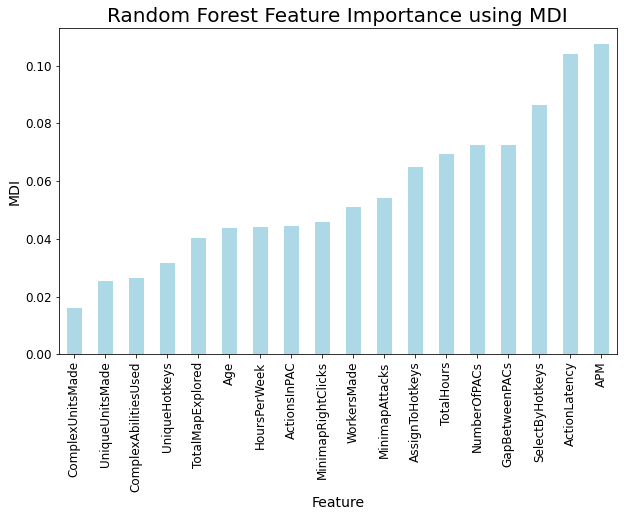

In [31]:
# create graph of feature importances from decision tree classification model
feature_importance = pd.DataFrame(importance, index=X.columns.values)
feature_importance = feature_importance.sort_values(0)
feature_importance.plot.bar(color='lightblue', figsize = (10,6)) # create bar plot


# chart formatting
plt.title('Random Forest Feature Importance using MDI', fontsize = 20) # chart title
plt.xlabel('Feature', fontsize=14) # x-axis label
plt.ylabel('MDI', fontsize=14) # y-axis label
plt.xticks(size=12) # x-axis tick font size
plt.yticks(size=12) # y-axis tick font size

# remove legend from figure
leg = plt.legend()
leg.remove()

plt.xticks(rotation = 90) # rotate x axis ticks
fig.tight_layout()
plt.savefig('fi_rf.png', bbox_inches='tight')
plt.show()

From our Random Forest model, we can see that ActionLatency was the most important variable in predicting LeagueIndex. Based on these feature importance scores, we will select a subset of 5 and 10 variables to be used for model testing. We will also use all variables as one of the subsets, meaning we will be testing 3 different combinations of variables.

### Model Testing

In [32]:
# split data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.25, random_state=0)

# create subsets of variables
set1 = feature_importance.index[-5:] # 5 most important variables
set2 = feature_importance.index[-10:] # 10 most important variables

# subset training set with top 5 variables
set1_indexes = tuple(X.columns.get_loc(col) for col in set1)
x_train1 = x_train[np.ix_(np.arange(x_train.shape[0]), set1_indexes)]
x_test1 = x_test[np.ix_(np.arange(x_test.shape[0]), set1_indexes)]


# subset training set with top 10 variables
set2_indexes = tuple(X.columns.get_loc(col) for col in set2)
x_train2 = x_train[np.ix_(np.arange(x_train.shape[0]), set2_indexes)]
x_test2 = x_test[np.ix_(np.arange(x_test.shape[0]), set2_indexes)]


In [33]:
def test_model(model, param_grid, algorithm):
    train = [x_train1, x_train2, x_train] # different training datasets for predictor variables
    test = [x_test1, x_test2, x_test] # different testing datasets for predictor variables
    variables = ['5 Variables','10 Variables','All Variables'] # labels for outputs
    accuracies = [] # create list to hold accuracies
    
    # use gridsearch for hyperparameter tuning and calculate accuracy for best model    
    for i in range(0,3):
        grid_search = GridSearchCV(model, param_grid, cv=4) # initiate gridsearch object
        grid_search.fit(X_scaled, y) # fit training data on gridsearch
        best_model = grid_search.best_estimator_ # select best model
        best_model.fit(train[i], y_train)
        accuracy = best_model.score(test[i], y_test) # fit best model on testing data
        accuracies.append([variables[i], accuracy, grid_search.best_params_])
    return pd.DataFrame(accuracies, columns = ['Variables',f'{algorithm} Accuracy','Parameters']) # return accuracies in a dataframe

### Logistic Regression (Baseline Model)

In [34]:
model = LogisticRegression(solver = 'newton-cg')
param_grid = {'penalty': ['none', 'l2'],
              'solver': ['newton-cg'],
              'max_iter': [200, 300, 400],
              'class_weight':['balanced'],
              'random_state': [0]}

lr_results = test_model(model, param_grid, 'Logistic Regression')
lr_results

,Variables,Logistic Regression Accuracy,Parameters
0,5 Variables,0.309776,"{'class_weight': 'balanced', 'max_iter': 200, ..."
1,10 Variables,0.359246,"{'class_weight': 'balanced', 'max_iter': 200, ..."
2,All Variables,0.346290,"{'class_weight': 'balanced', 'max_iter': 200, ..."


### Decision Tree

In [35]:
model = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
              'class_weight': ['balanced'],
              'random_state': [0]}
dt_results = test_model(model, param_grid, 'Decision Tree')
dt_results

,Variables,Decision Tree Accuracy,Parameters
0,5 Variables,0.300353,"{'class_weight': 'balanced', 'criterion': 'ent..."
1,10 Variables,0.319199,"{'class_weight': 'balanced', 'criterion': 'ent..."
2,All Variables,0.312132,"{'class_weight': 'balanced', 'criterion': 'ent..."


### Random Forest

In [36]:
model = RandomForestClassifier()
param_grid = {'n_estimators': [100, 200, 300],
              'criterion': ['gini', 'entropy'],
              'class_weight':['balanced'],
              'random_state': [0]}

rf_results = test_model(model, param_grid, 'Random Forest')
rf_results

,Variables,Random Forest Accuracy,Parameters
0,5 Variables,0.353357,"{'class_weight': 'balanced', 'criterion': 'gin..."
1,10 Variables,0.424028,"{'class_weight': 'balanced', 'criterion': 'gin..."
2,All Variables,0.429918,"{'class_weight': 'balanced', 'criterion': 'gin..."


### K-Nearest Neighbors

In [37]:
model = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(2,21))}
knn_results = test_model(model, param_grid, 'KNN')
knn_results

,Variables,KNN Accuracy,Parameters
0,5 Variables,0.375736,{'n_neighbors': 20}
1,10 Variables,0.381625,{'n_neighbors': 20}
2,All Variables,0.383981,{'n_neighbors': 20}


### Neural Network

In [38]:
model = MLPClassifier()
param_grid = {'hidden_layer_sizes': [(2,), (5,), (10,), (20,)],
              'max_iter': [400, 500, 600],
              'activation':['tanh','relu'], 
              'random_state': [0]}
nn_results = test_model(model, param_grid, 'Neural Network')
nn_results

/Users/davidshin/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidshin/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidshin/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidshin/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/davidshin/anacond

,Variables,Neural Network Accuracy,Parameters
0,5 Variables,0.367491,"{'activation': 'relu', 'hidden_layer_sizes': (..."
1,10 Variables,0.421673,"{'activation': 'relu', 'hidden_layer_sizes': (..."
2,All Variables,0.415783,"{'activation': 'relu', 'hidden_layer_sizes': (..."


### Boosted Tree

In [39]:
model = lgb.LGBMClassifier()
param_grid = {'n_estimators': [100, 200, 300],
              'learning_rate': [.01, .001],
              'num_leaves': [10, 31, 100],
              'class_weight':['balanced'],
              'random_state': [0]}

bt_results = test_model(model, param_grid, 'Boosted Tree')
bt_results

,Variables,Boosted Tree Accuracy,Parameters
0,5 Variables,0.338045,"{'class_weight': 'balanced', 'learning_rate': ..."
1,10 Variables,0.367491,"{'class_weight': 'balanced', 'learning_rate': ..."
2,All Variables,0.382803,"{'class_weight': 'balanced', 'learning_rate': ..."


### Best Model

In [40]:
model = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', n_estimators = 200, random_state = 0) # model with highest accuracy from testing
model.fit(x_train2, y_train) # fit model
predictions = model.predict(x_test2) # store predictions

In [41]:
best_model = pd.DataFrame({'Label': y_test, 'Prediction': predictions}) # create dataframe that has labels and predictions
best_model['Correct'] = np.where(best_model['Label'] == best_model['Prediction'], 1, 0) # create new column that indicates if prediction was correct
best_model.groupby('Label').mean()[['Correct']]

,Correct
Label,
1.0,0.500000
2.0,0.305556
3.0,0.259740
4.0,0.454106
5.0,0.425837
6.0,0.570470
7.0,0.000000
8.0,0.800000


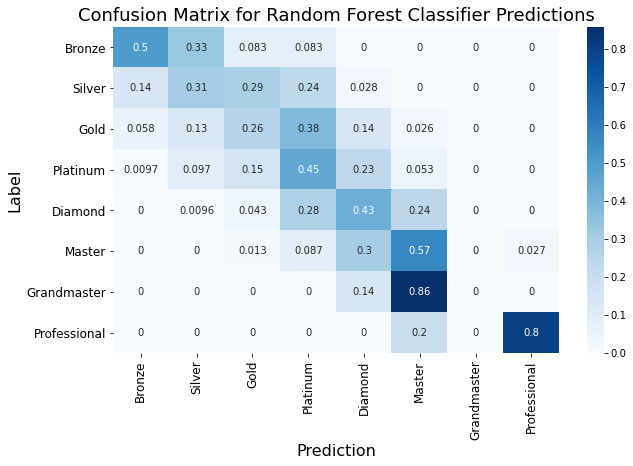

In [42]:
confusion_mat = confusion_matrix(y_test, predictions) # create confusion matrix

# convert counts to proportions
row_sums = confusion_mat.sum(axis=1) 
confusion_mat_proportions = confusion_mat / row_sums[:, np.newaxis]

# reformat ticks to have actual rank label
ticklabels = ['Bronze','Silver','Gold','Platinum','Diamond','Master','Grandmaster','Professional']

plt.figure(figsize=(10,6)) # figure size 
sns.heatmap(confusion_mat_proportions, xticklabels=ticklabels, yticklabels = ticklabels, annot = True, cmap = 'Blues')

# chart formatting
plt.title('Confusion Matrix for Random Forest Classifier Predictions', fontsize = 18) # set title
plt.xlabel('Prediction', fontsize = 16) # x axis label
plt.ylabel('Label', fontsize = 16) # y axis label
plt.xticks(fontsize = 12) # x tick font size
plt.yticks(fontsize = 12) # y tick font size
plt.savefig('cm', bbox_inches = 'tight')
plt.show()